<a href="https://colab.research.google.com/github/vggls/text_classification_fetch_20newsgroups/blob/main/nlp_ntbk_(fetch_20newsgroups_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import nltk
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.ensemble import GradientBoostingClassifier as GB # too slow during training, will probably skip it
from sklearn.naive_bayes import MultinomialNB  as MNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from keras.models import Model, Input
from keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
from keras.preprocessing.sequence import pad_sequences # https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split

**1.Dataset**

In [8]:
newsgroups_train = fetch_20newsgroups (subset='train',remove =('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups (subset='test',remove =('headers', 'footers', 'quotes'))

In [ ]:
print('Training data: {} samples'.format(len(newsgroups_train.data)))
print('Test data: {} samples'.format(len(newsgroups_test.data)))

Training data: 11314 samples
Test data: 7532 samples


In [ ]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
print(newsgroups_train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [ ]:
trainlst = []
for j in list(set(newsgroups_train.target)):
  trainlst.append(list(newsgroups_train.target).count(j))

fig = go.Figure(go.Bar(
            x=newsgroups_train.target_names,
            y=trainlst,
            text=trainlst))
fig.update_layout(height=400, width=900, title_text="Training set: Class distribution")
fig.show()

In [ ]:
testlst = []
for j in list(set(newsgroups_test.target)):
  testlst.append(list(newsgroups_test.target).count(j))

fig = go.Figure(go.Bar(
            x=newsgroups_test.target_names,
            y=testlst,
            text=testlst))
fig.update_layout(height=400, width=900, title_text="Test set: Class distribution")
fig.update_traces(marker_color='green')
fig.show()

**2.Machine Learning**



**2.1 Preprocessing - Tokenizers**

* Lower all characters (Tokenizer1, Tokenizer2)
* Tokenize each text segment via nltk word_tokenize, so as to obtain all the words (Tokenizer1, Tokenizer2)
* Remove words with length smaller than 3 characters (Tokenizer2)
* Remove some usual stopwords, for having a more clear version of each segment (Tokenizer2)
* Stem the remaining words, mapping some similar words as the same ones (e.g. faded or fading -> fade) (Tokenizer2)


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def Tokenizer1(str_input):

    #lower letters
    str_input = str_input.lower()

    #tokenize with nltk build-in function
    words = word_tokenize(str_input)

    return words

def Tokenizer2(str_input):

    #lower letters
    str_input = str_input.lower()

    #tokenize with nltk build-in function
    words = word_tokenize(str_input)
    
    #remove words with only 2 characters
    words = [word for word in words if len(word) > 2]
    
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    #stem the words
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]

    return words

In [ ]:
print('Example of using the tokenizer functions')
print(Tokenizer1(newsgroups_train.data[15])[:20])
print(Tokenizer2(newsgroups_train.data[15])[:20])

Example of using the tokenizer functions
['do', "n't", 'be', 'so', 'sure', '.', 'look', 'what', 'happened', 'to', 'japanese', 'citizens', 'in', 'the', 'us', 'during', 'world', 'war', 'ii', '.']
["n't", 'sure', 'look', 'happen', 'japanes', 'citizen', 'world', 'war', "'re", 'prepar', 'say', 'let', 'round', 'peopl', 'stick', 'concentr', 'camp', 'without', 'trial', 'short']


**2.2 Classification (Training and Testing)**

In "evaluate" function below we consider different values of the TfidfVectorizer hyperparameters : tokenizer, ngram_range, norm

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html



In [ ]:
#create multiple pipelines via for loops
def evaluate_and_test_ml():

  acc = 0
  X_train, X_val, y_train, y_val = train_test_split(newsgroups_train.data, newsgroups_train.target, test_size=0.2, random_state=42)

  for tokenizer in [Tokenizer1, Tokenizer2]:
    for ngrams in [(1,1), (1,2), (2,2)]:
      for norm in ['l1', 'l2']:
        for clf in [SVC(), MNB(), RandomForestClassifier()]:

          pipeline = Pipeline([('tfidf', TfidfVectorizer(tokenizer=tokenizer, ngram_range = ngrams, norm = norm)),
                               ('clf', clf)
                               ])
          pipeline.fit(X_train, y_train)
          predictions = pipeline.predict(X_val)
          loc_acc = accuracy_score(y_val, predictions)
          print('Evaluation of {} - {}ngrams- {}norm - {}clf model is complete'.format(tokenizer, ngrams, norm, clf))

          if loc_acc>acc:
            opt_tokenizer = tokenizer
            opt_ngrams = ngrams
            opt_norm = norm
            opt_clf = clf
            acc=loc_acc

  #once the optimal hyper-parameters are determinded, we train the model on the entire dataset
  opt_pipeline = Pipeline([('tfidf', TfidfVectorizer(tokenizer=opt_tokenizer, ngram_range = opt_ngrams, norm = opt_norm)),
                               ('clf', opt_clf)
                               ])
  opt_pipeline.fit(newsgroups_train.data, newsgroups_train.target)

  print('------------------------------------------------------------------------------------------------------------')
  print('The optimal pipeline was achieved for the following parameters :')
  print('tokenizer: {}'.format(opt_tokenizer))
  if sum(opt_ngrams)==2:x = 'uni-grams'
  elif sum(opt_ngrams)==3:x = 'uni-grams & bi-grams'
  else:x = 'bi-grams'
  print('n-grams: {}'.format(x))
  print('norm: {}'.format(opt_norm))
  print('classifier: {}'.format(opt_clf))
  print('-----------------------------------------------------------------')
  print('Classification report')
  test_predictions = opt_pipeline.predict(newsgroups_test.data)
  print(classification_report(newsgroups_test.target, test_predictions, target_names = newsgroups_test.target_names))

  return opt_pipeline

In [ ]:
evaluate_and_test_ml()

Evaluation of <function Tokenizer1 at 0x7eff7ac7aa70> - (1, 1)ngrams- l1norm - SVC()clf model is complete
Evaluation of <function Tokenizer1 at 0x7eff7ac7aa70> - (1, 1)ngrams- l1norm - MultinomialNB()clf model is complete
Evaluation of <function Tokenizer1 at 0x7eff7ac7aa70> - (1, 1)ngrams- l1norm - RandomForestClassifier()clf model is complete
Evaluation of <function Tokenizer1 at 0x7eff7ac7aa70> - (1, 1)ngrams- l2norm - SVC()clf model is complete
Evaluation of <function Tokenizer1 at 0x7eff7ac7aa70> - (1, 1)ngrams- l2norm - MultinomialNB()clf model is complete
Evaluation of <function Tokenizer1 at 0x7eff7ac7aa70> - (1, 1)ngrams- l2norm - RandomForestClassifier()clf model is complete
Evaluation of <function Tokenizer1 at 0x7eff7ac7aa70> - (1, 2)ngrams- l1norm - SVC()clf model is complete
Evaluation of <function Tokenizer1 at 0x7eff7ac7aa70> - (1, 2)ngrams- l1norm - MultinomialNB()clf model is complete
Evaluation of <function Tokenizer1 at 0x7eff7ac7aa70> - (1, 2)ngrams- l1norm - Rando

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function Tokenizer2 at 0x7eff7ac7ad40>)),
                ('clf', SVC())])

**3. Deep Learning**

**3.1 Preprocessing**

In [4]:
vocab_size = 20000

In [5]:
tokenizer = Tokenizer(num_words=vocab_size, lower=True, split=' ', oov_token="UNK")

In [9]:
def preprocess_train(list_of_texts, tokenizer, input_length):
    
    tokenizer.fit_on_texts(list_of_texts)
    tokenizer.word_index = {e: i for e,i in tokenizer.word_index.items() if i <= vocab_size}
    
    sequences = tokenizer.texts_to_sequences(list_of_texts)
    # maxlen =	Optional Int, maximum length of all sequences. If not provided, sequences will be padded to the length of the longest individual sequence. (see boxplot above)  
    sequences = pad_sequences(sequences, maxlen=input_length, value=0)
    
    return sequences

In [10]:
train_sequences = preprocess_train(newsgroups_train.data, tokenizer, input_length=200)

In [11]:
train_sequences.shape # one sequence per text !!!

(11314, 200)

In [12]:
def preprocess_test(list_of_texts, tokenizer, input_length):
       
    sequences = tokenizer.texts_to_sequences(list_of_texts)
    sequences = pad_sequences(sequences, maxlen=input_length, value=0)
    
    return sequences

In [13]:
test_sequences = preprocess_test(newsgroups_test.data, tokenizer, input_length=200)

In [14]:
test_sequences.shape

(7532, 200)

**3.2 Glove Embeddings**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
glove_dir ='/content/drive/MyDrive/'

embeddings_index = {} # We create a dictionary of word -> embedding

with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32') 
        embeddings_index[word] = embedding

print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

Found 400,000 word vectors in GloVe.


In [ ]:
word_index = tokenizer.word_index

In [ ]:
nb_words = min(vocab_size, len(word_index))

In [ ]:
embedding_dim = 100 # We use 100 dimensional glove vectors

embedding_matrix = np.zeros((nb_words, embedding_dim))

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= vocab_size: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(20000, 100)

**3.3 Classification**

In [ ]:
def dl_model(lstm_units, lstm_dropout):

  input_length = 200
  emb_dim = 100

  input_text = Input((input_length,))

  text_embedding = Embedding(vocab_size, 
                                emb_dim, 
                                weights = [embedding_matrix], 
                                trainable = False)(input_text)
  text_embedding = SpatialDropout1D(0.3)(text_embedding)

  bilstm = Bidirectional(LSTM(units=lstm_units, dropout=lstm_dropout, return_sequences=True))(text_embedding)
  x = concatenate([GlobalAveragePooling1D()(bilstm), GlobalMaxPooling1D()(bilstm)])
  
  x = Dropout(0.25)(x)
  x = Dense(512, activation="tanh")(x)
  x = Dropout(0.25)(x)
  x = Dense(512, activation="tanh")(x)
  x = Dropout(0.25)(x)
  x = Dense(256, activation="tanh")(x)
  x = Dropout(0.25)(x)
  x = Dense(128, activation="tanh")(x)
  x = Dropout(0.25)(x)
  
  out = Dense(units=20, activation="softmax")(x)
  
  model = Model(input_text, out)
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model

Below there is code for evaluating multiple deep learning models of the dl_model function architecture. In the experiments conducted multiple hyperparameters such as the number of dense layers, the number of nodes in the dense layers, the dropout value between the dense layers, the activation function (tanh or relu), the loss function, the optimizer and its learning rate, the lstm_units, lstm_dropout and batch_size were tuned. However, in the interest of space and time we eventually present structures that looked more promising. Thus, from the ones referenced above, we present results and graphs for the last three hyperparams only. 

Note that the MSE loss, the ReLU activation and the SGD optimizer were outperformed by Categorical Crossentropy, the tanh function and Adam in most of the cases. Same holds for learning rate different than 0.01. Thus, they were excluded at this point.

Training of model with lstm_units:128, lstm_dropout:0, batch_size:64 has ended
Training of model with lstm_units:128, lstm_dropout:0, batch_size:128 has ended
Training of model with lstm_units:128, lstm_dropout:0, batch_size:256 has ended
Training of model with lstm_units:128, lstm_dropout:0.25, batch_size:64 has ended
Training of model with lstm_units:128, lstm_dropout:0.25, batch_size:128 has ended
Training of model with lstm_units:128, lstm_dropout:0.25, batch_size:256 has ended
Training of model with lstm_units:128, lstm_dropout:0.5, batch_size:64 has ended
Training of model with lstm_units:128, lstm_dropout:0.5, batch_size:128 has ended
Training of model with lstm_units:128, lstm_dropout:0.5, batch_size:256 has ended
Training of model with lstm_units:256, lstm_dropout:0, batch_size:64 has ended
Training of model with lstm_units:256, lstm_dropout:0, batch_size:128 has ended
Training of model with lstm_units:256, lstm_dropout:0, batch_size:256 has ended
Training of model with lstm_u

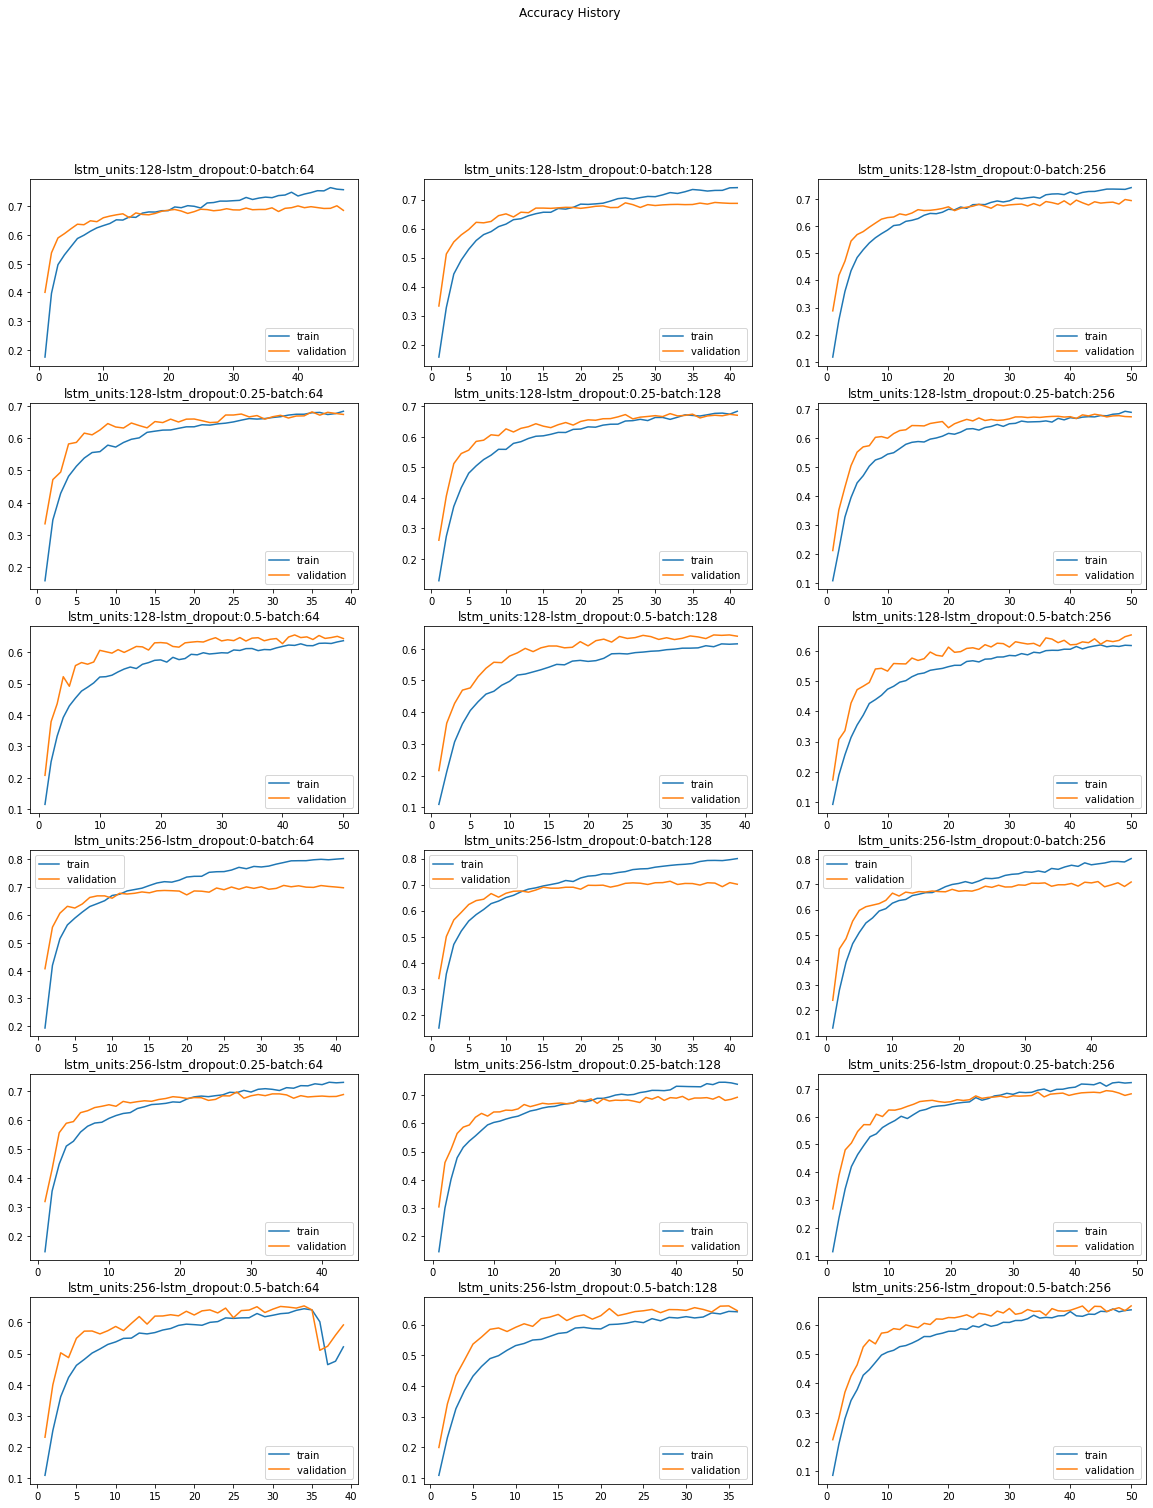

In [ ]:
earlystopping = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=15, verbose=0)

fig, ax = plt.subplots(6, 3, figsize=(20,24)) 
fig.suptitle("Accuracy History")

i = 0
j = 0
for lstm_units in [128, 256]:
  for lstm_dropout in [0, 0.25, 0.5]:
    for batch_size in [64, 128, 256]:

      history = dl_model(lstm_units, lstm_dropout).fit(train_sequences, newsgroups_train.target, 
                                                        batch_size=batch_size, 
                                                        epochs=50, 
                                                        verbose = 0,
                                                        validation_split=0.2,
                                                        callbacks=[earlystopping])
      
      epochs = len(history.history['accuracy'])
      x = range(1, epochs+1)
      ax[i, j].plot(x, history.history['accuracy'])
      ax[i, j].plot(x, history.history['val_accuracy'])
      ax[i, j].legend(['train', 'validation '])
      ax[i, j].set_title("lstm_units:{}-lstm_dropout:{}-batch:{}".format(lstm_units, lstm_dropout, batch_size))
      
      j += 1
      
      print('Training of model with lstm_units:{}, lstm_dropout:{}, batch_size:{} has ended'.\
            format(lstm_units, lstm_dropout, batch_size))
    i += 1
    j = 0    

Based on the above we will consider the following models for further study

Model 1:
*   lstm units = 128
*   lstm dropout = 0
*   batch size = 128

Model 2:


*   lstm units = 256
*   lstm dropout = 0
*   batch size = 256



In [ ]:
model_1 = dl_model(lstm_units = 128, lstm_dropout = 0)
model_1.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 200, 100)     2000000     ['input_25[0][0]']               
                                                                                                  
 spatial_dropout1d_24 (SpatialD  (None, 200, 100)    0           ['embedding_24[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_24 (Bidirectiona  (None, 200, 256)    234496      ['spatial_dropout1d_24[0][

In [ ]:
model_2 = dl_model(lstm_units = 256, lstm_dropout = 0)
model_2.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_25 (Embedding)       (None, 200, 100)     2000000     ['input_26[0][0]']               
                                                                                                  
 spatial_dropout1d_25 (SpatialD  (None, 200, 100)    0           ['embedding_25[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_25 (Bidirectiona  (None, 200, 512)    731136      ['spatial_dropout1d_25[0][

First we train both models in the entire training set (no validation part).
We use the same number of epochs (i.e. 40) as in the train-validation fit above.

In [ ]:
model_1.fit(train_sequences, newsgroups_train.target, 
            batch_size=128, 
            epochs=40, 
            verbose = 0)

In [ ]:
model_1.save('lstm_units:128 - lstm_dropout:0 - batch_size:128 .h5')

In [ ]:
model_2.fit(train_sequences, newsgroups_train.target, 
            batch_size=256, 
            epochs=40, 
            verbose = 0)

In [ ]:
model_2.save('lstm_units:256 - lstm_dropout:0 - batch_size:256 .h5')

Finally, we test the models :

In [ ]:
# for model_1
predictions_1 = model_1.predict(test_sequences)
y_pred_1 = np.argmax(predictions_1, axis = 1)

In [ ]:
print(classification_report(newsgroups_test.target, y_pred_1, target_names = newsgroups_test.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.50      0.38      0.43       319
           comp.graphics       0.72      0.59      0.65       389
 comp.os.ms-windows.misc       0.58      0.64      0.61       394
comp.sys.ibm.pc.hardware       0.63      0.58      0.60       392
   comp.sys.mac.hardware       0.55      0.69      0.62       385
          comp.windows.x       0.76      0.68      0.72       395
            misc.forsale       0.79      0.70      0.74       390
               rec.autos       0.47      0.70      0.57       396
         rec.motorcycles       0.58      0.82      0.68       398
      rec.sport.baseball       0.90      0.78      0.83       397
        rec.sport.hockey       0.93      0.86      0.89       399
               sci.crypt       0.80      0.67      0.73       396
         sci.electronics       0.61      0.53      0.57       393
                 sci.med       0.80      0.74      0.77       396
         

In [ ]:
# for model_2
predictions_2 = model_2.predict(test_sequences)
y_pred_2 = np.argmax(predictions_2, axis = 1)

In [ ]:
print(classification_report(newsgroups_test.target, y_pred_2, target_names = newsgroups_test.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.42      0.54      0.47       319
           comp.graphics       0.68      0.65      0.66       389
 comp.os.ms-windows.misc       0.71      0.55      0.62       394
comp.sys.ibm.pc.hardware       0.51      0.71      0.60       392
   comp.sys.mac.hardware       0.74      0.62      0.67       385
          comp.windows.x       0.76      0.76      0.76       395
            misc.forsale       0.83      0.69      0.75       390
               rec.autos       0.47      0.77      0.59       396
         rec.motorcycles       0.80      0.69      0.74       398
      rec.sport.baseball       0.78      0.82      0.80       397
        rec.sport.hockey       0.90      0.85      0.88       399
               sci.crypt       0.84      0.68      0.75       396
         sci.electronics       0.57      0.53      0.55       393
                 sci.med       0.80      0.74      0.77       396
         